ref: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb

ref_keras: https://github.com/hnarayanan/artistic-style-transfer/blob/master/notebooks/6_Artistic_style_transfer_with_a_repurposed_VGG_Net_16.ipynb

# 뉴럴 스타일 트랜스퍼(Neural Style Transfer)
- 원하는 이미지에 다른 이미지의 스타일을 입히는 기법
- Leon A. Gayts의 논문 A Neural Algorithm of Artistic Style에 기술되어 있음
- 이 과정은 출력이미지를 content의 통계량과 스타일 참조 이미지의 통계량에 맞춰 최적화시킴으로써 구현되며 통계량은 CNN을 이용해 각각의 이미지에서 추출

In [ ]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    
    return PIL.Image.fromarray(tensor)

* Image: https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg
* Style: https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('Kandinsky7.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

## Custom Data

In [ ]:
content_familiy_path = '/content/IMG_7334.JPG'
style_goh_path = '/content/Starry Night.jpeg'

# 입력 시각화
- 이미지를 불러오는 함수를 정의하고, 최대 이미지 크기를 512픽셀로 제한

In [ ]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

- 이미지를 출력하기 위한 간단한 함수를 정의

In [ ]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

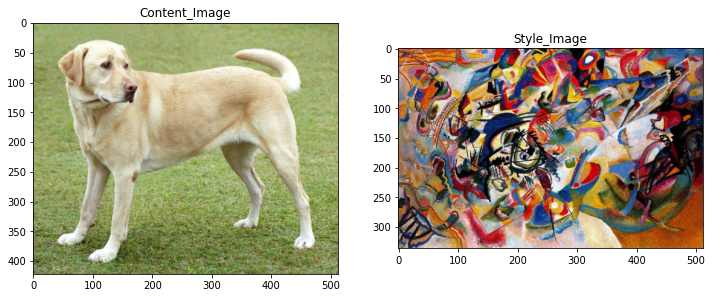

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content_Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style_Image')

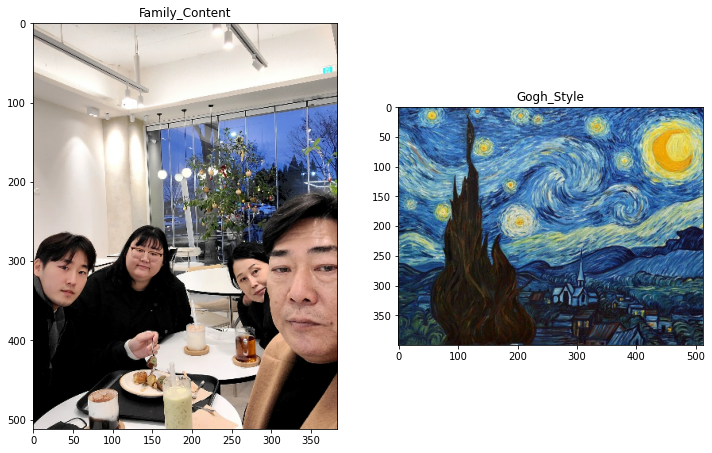

In [ ]:
content_f_image = load_img(content_familiy_path)
style_g_image = load_img(style_goh_path)

plt.subplot(1, 2, 1)
imshow(content_f_image, 'Family_Content')

plt.subplot(1, 2, 2)
imshow(style_g_image, 'Gogh_Style')

# TF-HUB를 이용한 빠른 Style Transfer

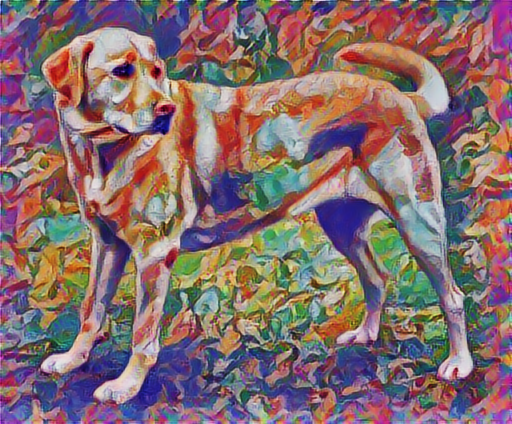

In [ ]:
import tensorflow_hub as hub
hub_module = hub.load('http://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

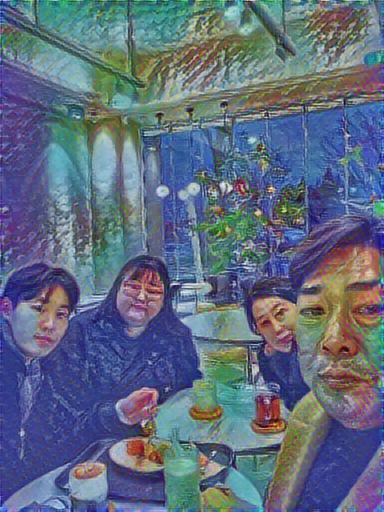

In [ ]:
stylized_f_image = hub_module(tf.constant(content_f_image), tf.constant(style_g_image))[0]
tensor_to_image(stylized_f_image)

# 콘텐츠와 스타일 표현 정의하기
- 모델의 입력층부터 시작해서, 처음 몇 개의 층은 선분이나 질감과 같은 이미지 내의 저차원적 특성에 반응
    - 반면, 네트워크가 깊어지면 최종 몇 개의 층은 바퀴나 눈과 같은 고차원적 특성들을 나타냄
- 이번 경우, 우리는 사전학습된 이미지 분류 네트워크인 VGG19 네트워크의 구조를 사용할 것이고, 이 중간층들은 이미지에서 콘텐츠와 스타일 표현을 정의하는 데 필요
    - 입력 이미지가 주어졌을 때, 스타일 전이 알고리즘은 이 중간층들에서 콘텐츠와 스타일에 해당하는 타겟 표현들을 일치시키려고 시도할 것

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_f_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('restaurant', 0.5053237),
 ('plate', 0.23040266),
 ('hot_pot', 0.05192617),
 ('dining_table', 0.04944148),
 ('wok', 0.035253853)]

- 분류층을 제외한 VGG19 모델을 불러오고, 각 층의 이름을 출력 

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

input_7
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


- 이미지의 스타일과 콘텐츠를 나타내기 위한 모델의 중간층들을 선택

In [ ]:
content_layers = ['block5_conv2']

# 레이어의 선택에 따라서 고차원적특징을 받아 올 것인지 저차원 특징을 받아올 것인지가 갈림
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# 스타일과 콘텐츠를 위한 중간층
- 사전 훈련된 이미지 분류 네트워크 속에 있는 중간 출력으로 어떻게 스타일과 콘텐츠를 정의 할 수 있을까?
    - 고수준에서 보면 (네트워크의 훈련 목적인) 이미지 분류를 수행하기 위해서는 네트워크가 반드시 이미지를 이해해야한다.
    - 이는 미가공 이미지를 입력으로 받아 픽셀값들을 이미지 내에 존재하는 특성(feature)들에 대한 복합적인 이해로 변환할 수 있는 내부 표현(internal representation)을 만드는 작업이 포함
    - 또한 부분적으로 왜 convolutional network는 일반화(generalize)가 쉽게 가능한지를 나타냄
      즉, CNN은 배경잡음(background noise)과 기타잡음(nuisances)에 관계없이 클래스 안에 있는 불변성(invariance)과 특징을 포착할 수 있음
    - 따라서 raw image의 input 과 output(label)의 중간 어딘가에서 모델은 복합 특성 (complex feature) 추출기의 역할을 수행
    - 그러므로, 모델의 중간층에 접근함으로써 입력 이미지의 콘텐츠와 스타일을 추출 할 수 있음

# 모델 생성
- 함수형 API를 사용해 모델을 정의하기 위해서는 모델의 입력과 출력을 지정
- model = Model(inputs, outputs)

In [ ]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print(" - 크기: ", output.numpy().shape)
    print(" - 최솟값: ", output.numpy().min())
    print(" - 최댓값: ", output.numpy().max())
    print(" - 평균: ", output.numpy().mean())
    

block1_conv1
 - 크기:  (1, 336, 512, 64)
 - 최솟값:  0.0
 - 최댓값:  835.5256
 - 평균:  33.97525
block2_conv1
 - 크기:  (1, 168, 256, 128)
 - 최솟값:  0.0
 - 최댓값:  4625.8564
 - 평균:  199.82213
block3_conv1
 - 크기:  (1, 84, 128, 256)
 - 최솟값:  0.0
 - 최댓값:  8790.341
 - 평균:  230.76958
block4_conv1
 - 크기:  (1, 42, 64, 512)
 - 최솟값:  0.0
 - 최댓값:  21565.012
 - 평균:  791.1809
block5_conv1
 - 크기:  (1, 21, 32, 512)
 - 최솟값:  0.0
 - 최댓값:  3188.5874
 - 평균:  59.17145


# 스타일 계산
- 이미지의 콘텐츠는 중간층들의 feature map의 값들로 표현

- 이미지의 스타일은 각 feature map의 평균과 feature map간 상관관계로 설명 할 수 있음

    - 이런 정보를 담고 있는 그람 행렬(Gram matrix)은 각 위치에서 특성 벡터(feature vector)끼리의 외적을 구한 후, 평균값을 냄으로써 구할 수 있음

    - 주어진 층에 대한 그람 행렬은 다음과 같이 계산

## $$ G^l_{cd} = \frac{\sum_{ij}F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

이 식은 tf.linalg.einsum 함수를 통해 쉽게 계산할 수 있습니다.

In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc, bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / (num_locations)

# 스타일과 컨텐츠 추출

- 스타일과 컨텐츠 텐서를 반환하는 모델

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[:self.num_style_layers])
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}        

- 이미지가 입력으로 주어졌을때, 이 모델은 style_layers의 스타일과 content_layers의 콘텐츠에 대한 그람 행렬을 출력

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_f_image))

print('Style: ')
for name, output in sorted(results['style'].items()):
    print(name)
    print(" - 크기: ", output.numpy().shape)
    print(" - 최솟값: ", output.numpy().min())
    print(" - 최댓값: ", output.numpy().max())
    print(" - 평균: ", output.numpy().mean())

print('Content: ')
for name, output in sorted(results['content'].items()):
    print(name)
    print(" - 크기: ", output.numpy().shape)
    print(" - 최솟값: ", output.numpy().min())
    print(" - 최댓값: ", output.numpy().max())
    print(" - 평균: ", output.numpy().mean())

Style: 
block1_conv1
 - 크기:  (1, 64, 64)
 - 최솟값:  0.109865844
 - 최댓값:  51507.344
 - 평균:  666.44617
block2_conv1
 - 크기:  (1, 128, 128)
 - 최솟값:  0.0
 - 최댓값:  155743.69
 - 평균:  23836.432
block3_conv1
 - 크기:  (1, 256, 256)
 - 최솟값:  0.0
 - 최댓값:  421122.4
 - 평균:  25450.068
block4_conv1
 - 크기:  (1, 512, 512)
 - 최솟값:  119.73722
 - 최댓값:  5356652.5
 - 평균:  390005.22
block5_conv1
 - 크기:  (1, 512, 512)
 - 최솟값:  0.0
 - 최댓값:  311297.16
 - 평균:  4324.6
Content: 
block5_conv2
 - 크기:  (1, 512, 384, 64)
 - 최솟값:  0.0
 - 최댓값:  840.9506
 - 평균:  22.332281


# 경사하강법 실행

- 타깃에 대한 입력 이미지의 MSE 계산 후 이 에러들의 가중합을 구함

- 스타일과 콘텐츠의 타깃값을 지정합니다

In [ ]:
style_targets = extractor(style_g_image)['style']
content_targets = extractor(content_f_image)['content']


- 최적화시킬 이미지를 담은 tf.Variable을 정의하고, 콘텐츠이미지로 초기화
- 이때 tf.Variable는 콘텐츠 이미지와 크기가 같아야 한다

In [ ]:
image = tf.Variable(content_f_image)

- 픽셀 값이 실수이므로 [0, 1] 사이로 clipping하는 함수 정의

In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

- 옵티마이저 생성

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

- 최적화를 진행하기 위해, 전체 오차를 콘텐츠와 스타일 오차의 가중합으로 진행

In [ ]:
style_weight = 1e-2
content_weight = 1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss

    return loss

- tf.GradientTape를 사용해 이미지를 업데이트

In [ ]:
# @tf.function()
# def train_step(image):
#     with tf.GradientTape() as tape:
#         outputs = extractor(image)
#         loss = style_content_loss(outputs)
    
#     grad = tape.gradient(loss, image)
#     opt.apply_gradients([(grad, image)])
#     image.assign(clip_0_1(image))

- 구현한 알고리즘 테스트

In [ ]:
# train_step(image)
# train_step(image)
# train_step(image)
# tensor_to_image(image)

# 총 변위 손실

- 위의 기본 구현 방식의 한가지 단점은 많은 고주파 아티팩(high frequency artifact)가 생겨난다는 점

- 아티팩 생성을 줄이기 위해서는 이미지의 고주파 구성 요소에 대한 regularization 항을 추가해야 함
    - 스타일 전이에서는 이 변형된 오차값을 총 변위 손실(total variation loss)라고 함 

In [ ]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var

- 아래의 이미지들은 고주파 구성 요소가 늘어났다는 점을 보여줌

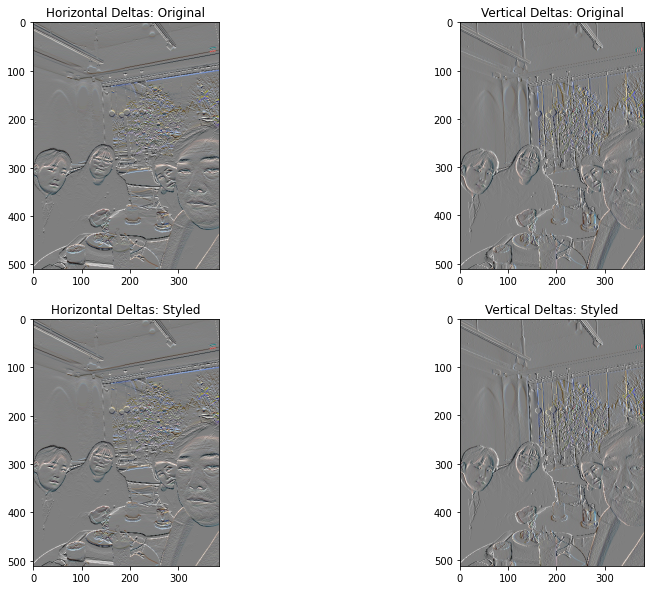

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_f_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)    
imshow(clip_0_1(2 * y_deltas + 0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)    
imshow(clip_0_1(2 * x_deltas + 0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)    
imshow(clip_0_1(2 * y_deltas + 0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)    
imshow(clip_0_1(2 * x_deltas + 0.5), "Vertical Deltas: Styled")


- (참고)

    - 고주파 구성 요소가 경계선 탐지기의 일종
    - 소벨 경계선 탐지기(Sobel edge detector)를 사용하면 유사한 출력을 얻음

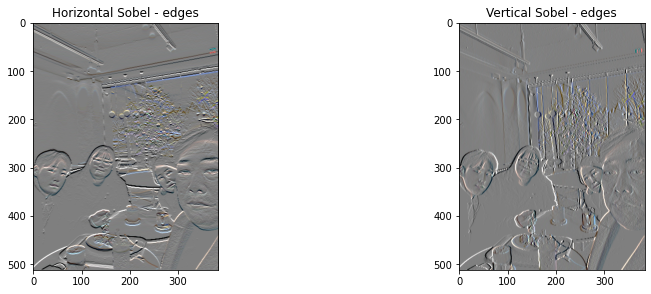

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_f_image)
plt.subplot(2, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4 + 0.5), 'Horizontal Sobel - edges')
plt.subplot(2, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4 + 0.5), 'Vertical Sobel - edges')

- 정규화 오차는 각 값의 절대값의 합으로 표현

In [ ]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image)

<tf.Tensor: shape=(), dtype=float32, numpy=46857.38>

In [ ]:
tf.image.total_variation(image).numpy()

array([46857.38], dtype=float32)

# 다시 최적화 진행하기

In [ ]:
total_variation_weight = 30

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

- 최적화할 변수를 다시 초기화

In [ ]:
image = tf.Variable(content_f_image)

- 최적화 수행

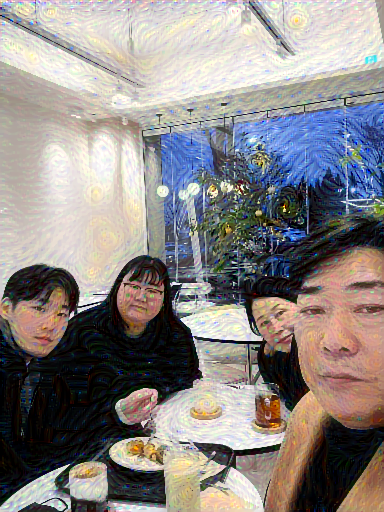

Training step: 1000
Elapsed time: 10.81589412689209


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Training step: {}".format(step))
end = time.time()
print("Elapsed time: {}".format(end-start))

# 결과 저장

In [ ]:
# file_name = 'stylized_image.png'
# tensor_to_image(image).save(file_name)

# from google.colab import files
# files.download(file_name)